# Azure embeddings example

This example will cover embeddings using the Azure OpenAI service.

## Setup

First, we install the necessary dependencies and import the libraries we will be using.

In [ ]:
! pip install "openai>=1.0.0,<2.0.0"

In [4]:
import os
import openai
import json

with open(r'../config.json') as config_file:
    config_details = json.load(config_file)
    
# Setting up the deployment name
deployment_name = config_details['EMBEDDINGS_MODEL']

# The base URL for your Azure OpenAI resource. e.g. "https://<your resource name>.openai.azure.com"
openai_api_url = config_details['OPENAI_API_URL']

# The API key for your Azure OpenAI resource.
openai_api_key = config_details['OPENAI_API_KEY']

# Currently OPENAI API have the following versions available: 2022-12-01
openai_api_version = config_details['OPENAI_API_VERSION']

### Authentication

The Azure OpenAI service supports multiple authentication mechanisms that include API keys and Azure Active Directory token credentials.

In [5]:
use_azure_active_directory = False  # Set this flag to True if you are using Azure Active Directory

#### Authentication using API key

To set up the OpenAI SDK to use an *Azure API Key*, we need to set `api_key` to a key associated with your endpoint (you can find this key in *"Keys and Endpoints"* under *"Resource Management"* in the [Azure Portal](https://portal.azure.com)). You'll also find the endpoint for your resource here.

In [9]:
if not use_azure_active_directory:

    client = openai.AzureOpenAI(
        azure_endpoint=openai_api_url,
        api_key=openai_api_key,
        api_version=openai_api_version
    )

#### Authentication using Azure Active Directory
Let's now see how we can authenticate via Azure Active Directory. We'll start by installing the `azure-identity` library. This library will provide the token credentials we need to authenticate and help us build a token credential provider through the `get_bearer_token_provider` helper function. It's recommended to use `get_bearer_token_provider` over providing a static token to `AzureOpenAI` because this API will automatically cache and refresh tokens for you. 

For more information on how to set up Azure Active Directory authentication with Azure OpenAI, see the [documentation](https://learn.microsoft.com/azure/ai-services/openai/how-to/managed-identity).

In [ ]:
! pip install "azure-identity>=1.15.0"

In [25]:
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

if use_azure_active_directory:
    endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
    api_key = os.environ["AZURE_OPENAI_API_KEY"]

    client = openai.AzureOpenAI(
        azure_endpoint=endpoint,
        azure_ad_token_provider=get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"),
        api_version="2023-09-01-preview"
    )

> Note: the AzureOpenAI infers the following arguments from their corresponding environment variables if they are not provided:

- `api_key` from `AZURE_OPENAI_API_KEY`
- `azure_ad_token` from `AZURE_OPENAI_AD_TOKEN`
- `api_version` from `OPENAI_API_VERSION`
- `azure_endpoint` from `AZURE_OPENAI_ENDPOINT`


## Deployments

In this section we are going to create a deployment of a model that we can use to create embeddings.

### Deployments: Create in the Azure OpenAI Studio
Let's deploy a model to use with embeddings. Go to https://portal.azure.com, find your Azure OpenAI resource, and then navigate to the Azure OpenAI Studio. Click on the "Deployments" tab and then create a deployment for the model you want to use for embeddings. The deployment name that you give the model will be used in the code below.

In [7]:
deployment = "text-embedding-ada-002" # Fill in the deployment name from the portal here

## Embeddings

Now let's create embeddings using the client we built.

In [12]:
embeddings = client.embeddings.create(
    model=deployment,
    input="The food was delicious and the waiter..."
)
                                
print(embeddings.data[0].embedding)

[0.0023481972, -0.009284899, 0.01570119, -0.007710972, -0.0047217803, 0.014863454, -0.009849736, -0.038281962, -0.006930355, -0.028660698, 0.025182828, 0.018112851, -0.0036048, -0.02557631, 0.00049978524, -0.016361222, 0.02827991, 0.0053500817, 0.009652995, -0.016386608, -0.015396558, 0.0042584874, 0.0070065125, -0.0072413324, -0.0038491394, 0.018506333, 0.008707369, -0.022682315, 0.011474433, 0.023926225, 0.015625032, -0.0034905635, -0.03493102, -0.004160117, -0.026147492, -0.021539949, -0.0056325, 0.011785411, 0.00845351, 0.004122038, 0.019204445, -0.014444586, 0.008973921, 0.006378211, -0.04569465, 0.0178463, -0.0055595157, -0.00071754877, -0.022136519, -0.0038999112, 0.02103223, -0.017579747, -0.011702907, -0.022644237, 0.016361222, 0.017198958, -0.008409085, 0.0016405648, 0.025132056, -0.024967048, 0.007825209, 0.005778469, -0.022161905, 0.0029098606, -0.006127525, -0.02553823, -0.008079068, 0.0010011571, 0.00018355207, 0.0046297563, 0.020803757, 0.013454535, 0.004661489, -0.01591

# Ejercicio 1: Generar múltiples embeddings y calcular similitud entre frases
## Objetivo: Aprender a generar embeddings para múltiples textos y calcular similitudes entre ellos.


In [ ]:
! pip install scikit-learn numpy

In [15]:

# Lista de textos a procesar
texts = [
    "The weather is sunny and warm.",
    "It's a cold and rainy day.",
    "I love spending time at the beach.",
    "Reading books indoors on a rainy day is relaxing."
]

# Crear embeddings para cada texto
embeddings_list = []
for text in texts:
    response = client.embeddings.create(
        model=deployment,
        input=text
    )
    embeddings_list.append(response.data[0].embedding)

# Calcular la similitud coseno entre embeddings
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

similarity_matrix = cosine_similarity(np.array(embeddings_list))

# Mostrar la matriz de similitud
print("Matriz de similitud:")
print(similarity_matrix)


Matriz de similitud:
[[1.         0.86871754 0.81671393 0.80782677]
 [0.86871754 1.         0.7727784  0.86608481]
 [0.81671393 0.7727784  1.         0.80021672]
 [0.80782677 0.86608481 0.80021672 1.        ]]


# Ejercicio 2: Reducción de dimensionalidad y visualización de embeddings
## Objetivo: Visualizar la relación entre embeddings utilizando reducción de dimensionalidad (TSNE o PCA).


In [ ]:
! pip install matplotlib

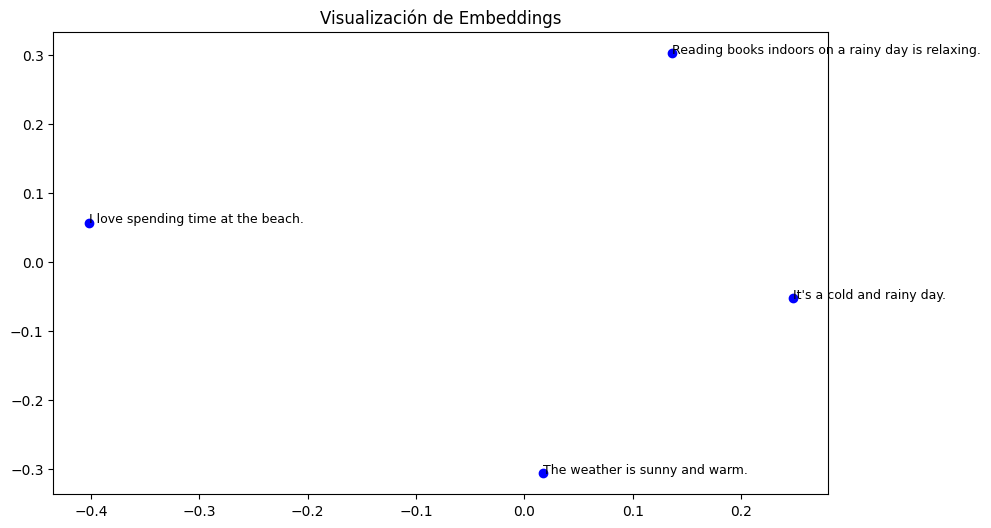

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducir a 2 dimensiones
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_list)

# Graficar los embeddings
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue')
for i, text in enumerate(texts):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], text, fontsize=9)
plt.title("Visualización de Embeddings")
plt.show()

# Ejercicio 3: Detección de temas con clustering de embeddings
## Objetivo: Agrupar textos con embeddings similares utilizando k-means.

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(embeddings_list)
labels = kmeans.labels_

# Mostrar resultados de clustering
for i, text in enumerate(texts):
    print(f"Texto: {text} - Cluster: {labels[i]}")

Texto: The weather is sunny and warm. - Cluster: 0
Texto: It's a cold and rainy day. - Cluster: 0
Texto: I love spending time at the beach. - Cluster: 1
Texto: Reading books indoors on a rainy day is relaxing. - Cluster: 1


Ahora, vamos a añadir una condición para hacer etiquetas, donde el valor 0 va a ser "weather status" y el valor 1 correspondrá a "not-weather status"

In [21]:
for i, text in enumerate(texts):
    if labels[i] == 0:
        print(f"Texto: {text} - Label: Weather status")
    else:
        print(f"Texto: {text} - Cluster: Not weather status")

Texto: The weather is sunny and warm. - Label: Weather status
Texto: It's a cold and rainy day. - Label: Weather status
Texto: I love spending time at the beach. - Cluster: Not weather status
Texto: Reading books indoors on a rainy day is relaxing. - Cluster: Not weather status


# Ejercicio 4: Construcción de un motor de búsqueda simple con embeddings
## Objetivo: Implementar un motor de búsqueda que retorne el texto más similar a una consulta usando embeddings.


In [22]:
query = "I enjoy sunny days at the beach."
response = client.embeddings.create(
    model=deployment,
    input=query
)
query_embedding = response.data[0].embedding

# Calcular similitud entre la consulta y la lista de textos anteriores
similarities = cosine_similarity([query_embedding], embeddings_list)[0]
most_similar_index = np.argmax(similarities)

print("Consulta:", query)
print("Texto más similar:", texts[most_similar_index])

Consulta: I enjoy sunny days at the beach.
Texto más similar: I love spending time at the beach.
